In [1]:
using Plots

# Exercise 1

In [218]:
module ProjectedGradient
using LinearAlgebra: norm

function backtrack(alpha0, rho, btmax, f, gradf, xk, c1, pk)
    bt = 0
    alpha = alpha0
    while bt < btmax && f(xk + alpha * pk) >= (f(xk) + c1 * alpha * gradf(xk)'*pk)
        alpha = rho * alpha
        bt = bt + 1
    end
    
    return (bt, alpha)
end

function constrained_steepest_descent_backtrack(
        x0, f, grad_f, kmax, # regular steepest descent arguments
        alpha0, rho, btmax, c1, # backtracking parameters
        gamma, tolx, Pi_x # 
    )
    k = 0
    xk = x0
    
    xseq = []
    btseq = []
    
    while true
        # max iterations stopping conditions
        if k > kmax
            break
        end
        
        push!(xseq, xk)
        
        # 1. compute descent direction
        pk = -grad_f(xk)
        
        # 2. apply descent step and project inside feasible set
        xk_bar = xk + gamma * pk
        xk_hat = Pi_x(xk_bar)
        
        # 3. compute direction from xk to projected point xk_hat
        pik = xk_hat - xk
        
        # 4. apply descent step, with backtracking
        bt, alpha = backtrack(alpha0, rho, btmax, f, grad_f, xk, c1, pk)
        push!(btseq, bt)
        xkplus1 = xk + alpha * pik
        
        # update length stopping condition
        if norm(xkplus1 - xk) < tolx
            break
        end
        
        xk = xkplus1
        k = k + 1
    end
    
    return xk, f(xk), k, xseq, btseq
end

end

using Main.ProjectedGradient

In [219]:
f(x) = x'x
grad_f(x) = [2*x[1], 2*x[2]]

xk, fk, k, xseq, btseq = ProjectedGradient.constrained_steepest_descent_backtrack(
    [5,5], f, grad_f, 1_000,
    1, 0.8, 50, 1e-2,
    1e-1, 1e-8, (x) -> x
)

@show xk
@show fk
@show k
;

xk = [3.952333768435542e-8, 3.952333768435542e-8]
fk = 3.1241884434231785e-15
k = 107


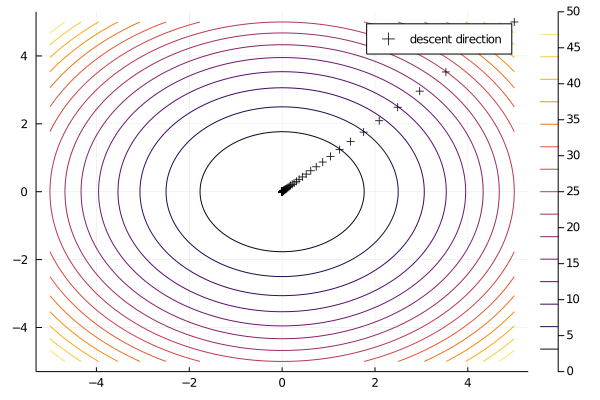

In [220]:
contour(-5:0.05:5, -5:0.05:5, (x1, x2) -> f([x1, x2]))
scatter!([x[1] for x in xseq], [x[2] for x in xseq], m=:+, c=:black, label="descent direction")

# Exercise 2

In [221]:
"""
returns whether x is inside the box defined by mins and maxes. mins and maxes are inclusive
"""
function inside_box(x, mins, maxs)
    for (i, (m, M)) in enumerate(zip(mins, maxs))
        if x[i] < m || x[i] > M
            return false
        end
    end
    return true
end

function box_projection(x, mins, maxs)
    x_new = similar(x)
    for (i, (m, M)) in enumerate(zip(mins, maxs))
        if x[i] < m
            x_new[i] = m
        elseif x[i] > M
            x_new[i] = M
        else
            x_new[i] = x[i]
        end
    end
    return x_new
end

box_projection (generic function with 1 method)

xk = [2.0, 5.678903215122536e-8]
fk = 4.0000000000000036
k = 102


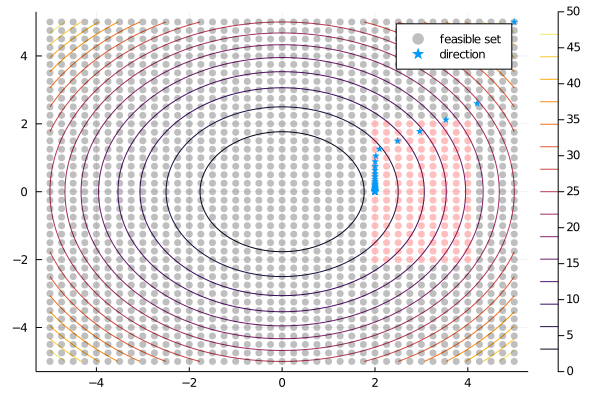

In [222]:
f(x) = x'x
grad_f(x) = [2*x[1], 2*x[2]]

xk, fk, k, xseq, btseq = ProjectedGradient.constrained_steepest_descent_backtrack(
    [5,5], f, grad_f, 1_000,
    1, 0.8, 50, 1e-2,
    1e-1, 1e-8, (x) -> box_projection(x, [2,-2], [4,2])
)

@show xk
@show fk
@show k

contour(-5:0.05:5, -5:0.05:5, (x1, x2) -> f([x1, x2]))
scatter!(
    [x1 for x1 in -5:0.25:5 for x2 in -5:0.25:5],
    [x2 for x1 in -5:0.25:5 for x2 in -5:0.25:5],
    c=[inside_box([x1,x2], [2,-2], [4,2]) ? :red : :black for x1 in -5:0.25:5 for x2 in -5:0.25:5],
    markerstrokewidth=0,
    markeralpha=0.25,
    label="feasible set"
)
scatter!([x[1] for x in xseq], [x[2] for x in xseq], m=:star,label="direction",markerstrokewidth=0, c=1)

# Exercise 3

In [223]:
using LinearAlgebra: norm

In [224]:
inside_sphere(x, xc, r) = norm(x - xc) < r

function sphere_projection(x, xc, r)
    if norm(x - xc) < r
        return x
    end
    
    p = x - xc
    q = (r / norm(p)) * p
    R = q + xc
    
    return R
end

@show sphere_projection([0.5, 0.5], [0, 0], 1)
@show sphere_projection([1.5, 0.5], [0, 0], 1)
;

sphere_projection([0.5, 0.5], [0, 0], 1) = [0.5, 0.5]
sphere_projection([1.5, 0.5], [0, 0], 1) = [0.9486832980505138, 0.31622776601683794]


xk = [1.0000000000000004, 3.1996493756945745e-8]
fk = 1.000000000000002
k = 60


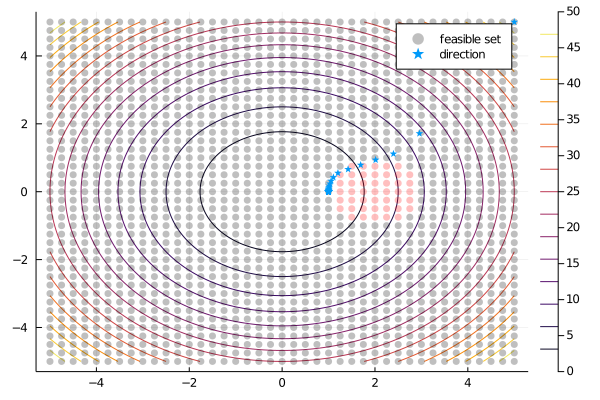

In [225]:
f(x) = x'x
grad_f(x) = [2*x[1], 2*x[2]]

xk, fk, k, xseq, btseq = ProjectedGradient.constrained_steepest_descent_backtrack(
    [5,5], f, grad_f, 1_000,
    1, 0.8, 50, 1e-2,
    1e-1, 1e-8, (x) -> sphere_projection(x, [2,0], 1)
)

@show xk
@show fk
@show k

contour(-5:0.05:5, -5:0.05:5, (x1, x2) -> f([x1, x2]))
scatter!(
    [x1 for x1 in -5:0.25:5 for x2 in -5:0.25:5],
    [x2 for x1 in -5:0.25:5 for x2 in -5:0.25:5],
    c=[inside_sphere([x1,x2], [2,0], 1) ? :red : :black for x1 in -5:0.25:5 for x2 in -5:0.25:5],
    markerstrokewidth=0,
    markeralpha=0.25,
    label="feasible set"
)
scatter!([x[1] for x in xseq], [x[2] for x in xseq], m=:star,label="direction",markerstrokewidth=0, c=1)